# Setting up

In [ ]:
pip install shap==0.40.0

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shap

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.random import set_seed

from preprocessing import load_wisconsin_prepr

# Interpretability measures
from interpretability import PDP

In [18]:
def find_best_model(model, parameters, X_train, y_train): 
    clf = GridSearchCV(model, parameters, scoring=('balanced_accuracy'), cv=StratifiedKFold())
    clf.fit(X_train, y_train)

    return clf

# Calculates the per-class accuracy given predicted and true output labels.
def class_accs(y_pred, y_true):
    acc0 = ((y_pred == y_true) & (y_true == 0)).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).sum() / (y_true == 1).sum()
    return acc0, acc1

# Prints a summary of performance metrics given predicted and true output labels.
def print_metrics(y_pred, y_true):
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    print(f'F1 = {f1}')
    print(f'Accuracy = {acc}')
    print(f'\tclass 0: {acc0}')
    print(f'\tclass 1: {acc1}')

def classify(output: np.ndarray):
    return (output > 0.5).astype(int)

def print_errors(clf, model_name, X_test, y_test):
    y_pred = clf.predict(X_test)
    if model_name == "neural network":
        y_pred = np.reshape(y_pred, len(y_test))
        y_pred = classify(y_pred)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced accuracy ({}) = {}".format(model_name, bal_acc))
    print_metrics(y_pred, y_test)

In [6]:
X, y, feature_names = load_wisconsin_prepr()
seed = 3011

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [25]:
X_train_df = pd.DataFrame(data=X_train, columns=feature_names)
X_train_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.635423,-0.218663,-0.603397,-0.633351,-0.194302,0.209585,-0.281725,-0.451373,0.567289,0.048537,-0.392942,0.628029,-0.385658,-0.415328,0.610365,0.918928,0.914016,0.981995,0.894492,0.370723,-0.625221,0.231690,-0.627326,-0.614185,0.356447,0.320201,0.040354,-0.012276,0.802814,-0.016393
1,1.080023,1.207830,0.956888,0.978402,-0.555822,-0.645696,-0.399365,-0.038153,-0.998966,-1.091216,0.057848,0.392164,-0.050027,0.120414,-0.532348,-0.770613,-0.519694,-0.531097,-0.769127,-0.394858,0.963102,1.467675,0.829202,0.772457,-0.038076,-0.468613,-0.307946,-0.015321,-0.641864,-0.247477
2,0.324545,-1.484587,0.255419,0.200825,-1.034766,-0.796739,-0.375134,-0.447504,-1.652485,-1.068535,-0.692146,-1.549547,-0.663865,-0.447451,-0.916697,-0.733167,-0.447080,-0.717476,-1.332263,-0.809043,0.230029,-1.588903,0.191785,0.091617,-0.445749,-0.226880,0.115196,-0.169110,-0.939535,-0.510148
3,-0.101476,-1.400813,-0.161014,-0.205313,-0.311725,-0.798444,-0.981414,-0.767349,-0.801815,-0.521339,-0.671573,-0.947547,-0.686637,-0.497174,-0.897696,-0.968294,-0.915854,-0.805718,0.120800,-0.753819,-0.331164,-1.424431,-0.389933,-0.385832,-0.673696,-0.935539,-1.126787,-0.861616,-0.125792,-0.886975
4,-1.570397,0.393356,-1.536767,-1.231750,1.988342,-0.278795,-0.738224,-1.022993,0.059807,0.676536,-0.169532,1.542458,-0.184676,-0.482873,1.629740,0.343266,-0.062790,-0.411548,1.577375,-0.282517,-1.388321,0.221920,-1.346356,-1.066496,1.382207,-0.537316,-0.874006,-1.322068,0.115258,-0.378258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,-0.709266,2.327149,-0.704313,-0.681985,-0.198572,-0.352516,-0.215937,-0.741555,-0.046070,-0.161268,-0.330864,2.193808,-0.354471,-0.378585,0.940045,-0.072552,0.359962,-0.418685,0.509462,-0.630509,-0.652142,2.138591,-0.632092,-0.620162,0.360831,-0.325481,0.096485,-0.704325,-0.027107,-0.650904
451,-0.871154,-0.504892,-0.853421,-0.820208,1.639632,0.052287,-0.604764,-0.160932,0.519826,2.404595,-0.820273,-0.339016,-0.766337,-0.616864,1.859749,-0.111675,-0.460674,0.170947,0.200712,1.708976,-0.948270,-0.803996,-0.928759,-0.825310,1.483030,-0.325481,-0.703262,-0.296404,-0.195356,1.820641
452,-0.717787,1.210157,-0.730674,-0.676012,-1.538617,-0.899456,-0.867038,-0.923145,0.450458,-0.569538,-0.555717,1.032628,-0.448032,-0.486834,-0.306339,-0.117823,-0.528315,-0.778304,1.380017,-0.599114,-0.792958,0.967744,-0.770596,-0.710343,-1.618359,-0.751695,-0.958538,-1.011902,0.555294,-0.914129
453,-0.649623,-0.081366,-0.677951,-0.645296,-0.544436,-0.669764,-0.779781,-0.902509,-1.017221,-0.315787,-0.660385,-0.638020,-0.703963,-0.510815,-0.508014,-0.458749,-0.379440,-0.819019,-0.530602,-0.330177,-0.614867,-0.111910,-0.656516,-0.587641,-0.191501,-0.421538,-0.600115,-0.692448,-0.591712,-0.222540


# Training models

# Scikit-learn models

In [26]:
model_names = [
    "k-nearest neighbors", 
    "decision tree classifier",
    "support vector classifier",
    ]

parameters = {
    "k-nearest neighbors": {'n_neighbors': np.arange(1, 20), 'weights': ('uniform', 'distance')}, # 'n_neighbors': np.arange(1, 364)
    "decision tree classifier": {'criterion': ('gini', 'entropy'), 'min_samples_split': np.arange(2, 20)}, # 'min_samples_split': np.arange(2, 364)
    "support vector classifier": {'C': np.geomspace(0.01, 100, 41)}
    }

models_init = {
    "k-nearest neighbors": KNeighborsClassifier(),
    "decision tree classifier": DecisionTreeClassifier(random_state=seed),
    "support vector classifier": SVC(kernel="linear")
    }

models = dict()

for model_name in model_names:
    clf = find_best_model(models_init[model_name], parameters[model_name], X_train_df, y_train)
    models[model_name] = clf.best_estimator_

In [27]:
model_name = "k-nearest neighbors"
model = models[model_name]
model.feature_names_in_

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype=object)

## Neural network

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.2, random_state=seed, stratify=y_)

In [ ]:
# Initialise neural network
BATCH_SIZE=64
INPUT_SIZE= X_train.shape[1]

set_seed(seed)

model = Sequential()
model.add(Input(INPUT_SIZE))
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(5, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam',
                loss="binary_crossentropy",
                metrics='binary_accuracy')

n_epochs = 1629
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=n_epochs, validation_data=(X_val, y_val)) # validation_split=0.2)

models["neural network"] = model

6/6 [==============================] - 0s 20ms/step - loss: 0.0013 - binary_accuracy: 1.0000 - val_loss: 2.6916e-04 - val_binary_accuracy: 1.0000
Epoch 1131/1629
6/6 [==============================] - 0s 16ms/step - loss: 0.0037 - binary_accuracy: 1.0000 - val_loss: 2.7034e-04 - val_binary_accuracy: 1.0000
Epoch 1132/1629
6/6 [==============================] - 0s 15ms/step - loss: 0.0080 - binary_accuracy: 0.9982 - val_loss: 3.1660e-04 - val_binary_accuracy: 1.0000
Epoch 1133/1629
6/6 [==============================] - 0s 17ms/step - loss: 0.0027 - binary_accuracy: 1.0000 - val_loss: 3.3633e-04 - val_binary_accuracy: 1.0000
Epoch 1134/1629
6/6 [==============================] - 0s 25ms/step - loss: 0.0036 - binary_accuracy: 0.9992 - val_loss: 1.3182e-04 - val_binary_accuracy: 1.0000
Epoch 1135/1629
6/6 [==============================] - 0s 20ms/step - loss: 0.0032 - binary_accuracy: 1.0000 - val_loss: 1.4533e-05 - val_binary_accuracy: 1.0000
Epoch 1136/1629
6/6 [=======================

## Errors

In [ ]:
for model_name in models.keys():
    print_errors(models[model_name], model_name, X_test, y_test)

Balanced accuracy (k-nearest neighbors) = 0.9692460317460317
F1 = 0.9793103448275863
Accuracy = 0.9736842105263158
	class 0: 0.9523809523809523
	class 1: 0.9861111111111112
Balanced accuracy (decision tree classifier) = 0.9295634920634921
F1 = 0.943661971830986
Accuracy = 0.9298245614035088
	class 0: 0.9285714285714286
	class 1: 0.9305555555555556
Balanced accuracy (support vector classifier) = 0.9404761904761905
F1 = 0.9664429530201343
Accuracy = 0.956140350877193
	class 0: 0.8809523809523809
	class 1: 1.0
Balanced accuracy (neural network) = 0.9761904761904762
F1 = 0.9863013698630138
Accuracy = 0.9824561403508771
	class 0: 0.9523809523809523
	class 1: 1.0


# Intrinsic interpretability

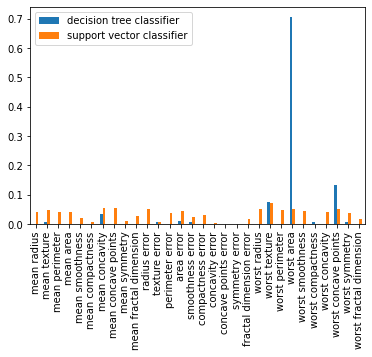

,decision tree classifier,support vector classifier
mean radius,0.000000,0.040542
mean texture,0.007857,0.048713
mean perimeter,0.000000,0.039841
mean area,0.000000,0.041319
mean smoothness,0.000000,0.020760
mean compactness,0.000000,0.008318
mean concavity,0.033610,0.055165
mean concave points,0.000000,0.056606
mean symmetry,0.000000,0.009626
mean fractal dimension,0.000000,0.028195


In [ ]:
dtr_feat_imps = models["decision tree classifier"].feature_importances_

svc_coefs = models["support vector classifier"].coef_[0]
svc_feat_imps = np.abs(svc_coefs) / np.sum(np.abs(svc_coefs))

feat_imps = pd.DataFrame({"decision tree classifier": dtr_feat_imps, "support vector classifier": svc_feat_imps}, index=feature_names)
feat_imps.plot.bar()
plt.show()

feat_imps

# Partial dependence plot

k-nearest neighbors


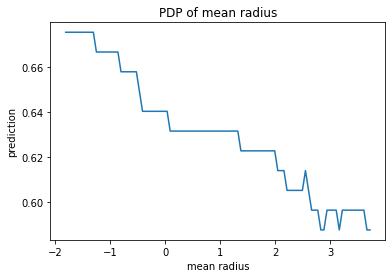

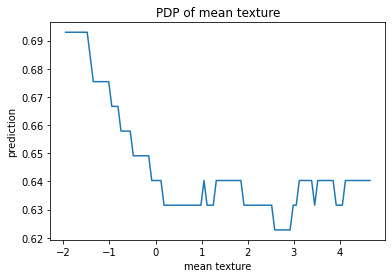

decision tree classifier


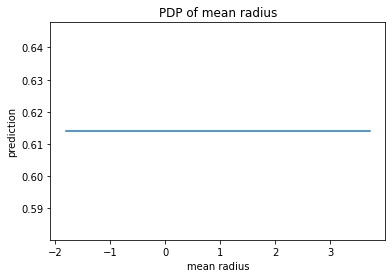

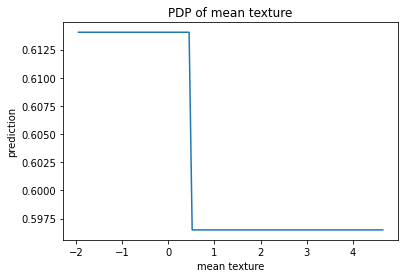

support vector classifier


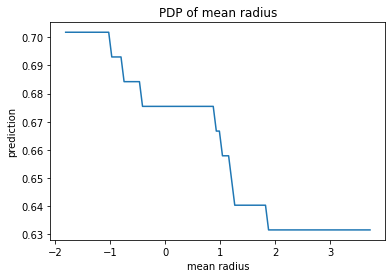

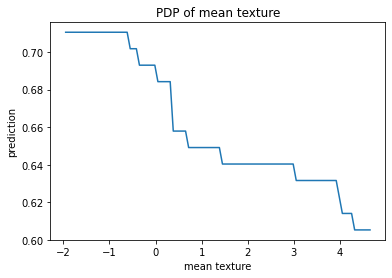

neural network


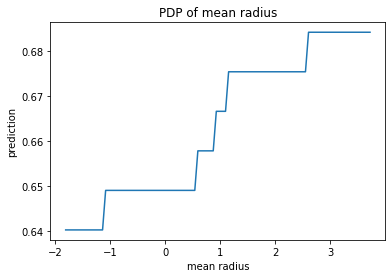

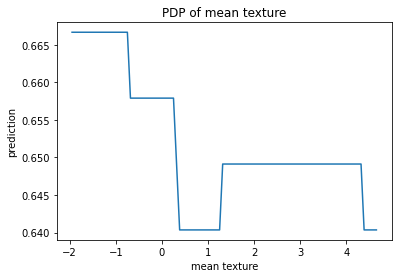

In [ ]:
for model_name in models.keys():
    model = models[model_name]
    print(model_name)

    for i in range(2): # range(X_test.shape[1]):
        PDP(i, feature_names[i], model, X_test, y_test, categorical=False)
        plt.show()
        plt.close()

# SHAP

## Instance-based interpretability

In [ ]:
explainers = dict()

for model_name in models.keys():
  model = models[model_name]

  if model_name == "neural network":
    def nn_predict(X):
      y_pred = model.predict(X)
      y_pred = np.reshape(y_pred, X.shape[0])
      return classify(np.array(y_pred))

    explainers[model_name] = shap.KernelExplainer(nn_predict, X_train)
  else:
    explainers[model_name] = shap.KernelExplainer(model.predict, X_train)

Using 364 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 364 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 364 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Using 364 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
idx = 4
model_name = "k-nearest neighbors"

X_test_df = pd.DataFrame(X_test, columns=feature_names)

explainer = explainers[model_name]
shap_test = explainer.shap_values(X_test_df.iloc[idx])

# PLOT SHAPLEY VALUES IN NORMAL WAY

shap.initjs()
shap.force_plot(explainer.expected_value, shap_test, X_test_df.iloc[idx])
# shap.force_plot(explainer.expected_value[1], shap_test[1], X_test_df.iloc[idx]) # for decision trees

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


## Global interpretation

In [ ]:
shap_values_all = dict()
X_test_df = pd.DataFrame(X_test, columns=feature_names)

for model_name in models.keys():
    print(model_name)
    explainer = explainers[model_name]
    shap_values = explainer.shap_values(X_test_df.iloc[:5])
    if model_name == "decision tree classifier":
        shap_values = shap_values[1]
    shap_values_all[model_name] = shap_values

  0%|          | 0/5 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 


KeyboardInterrupt: 

In [ ]:
shapley_feat_imps = pd.DataFrame(index=feature_names)

for model_name in models.keys():
  shap_values = shap_values_all[model_name]
  feat_imps = np.mean(np.abs(shap_values), axis=0)
  feat_imps /= np.sum(feat_imps)
  shapley_feat_imps.insert(0, model_name, feat_imps)

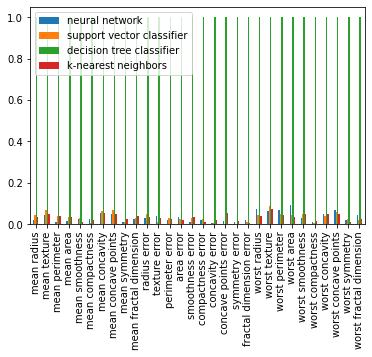

In [ ]:
shapley_feat_imps.plot.bar()
plt.show()

# Counterfactuals

In [ ]:
pip install dice_ml

In [ ]:
import dice_ml
from dice_ml.utils import helpers


## we need the data in pd format
y_test_df = pd.DataFrame(y_test, columns=["cell type"])
X_test_df = pd.DataFrame(X_test, columns=feature_names)
dice_df = pd.concat([X_test_df, y_test_df], axis=1)

dice_df

model_name = "k-nearest neighbors"
# for model_name in models.keys():
model = models[model_name]

d = dice_ml.Data(dataframe=dice_df, continuous_features=['mean radius', 'mean texture', 'mean perimeter', 'mean area',
      'mean smoothness', 'mean compactness', 'mean concavity',
      'mean concave points', 'mean symmetry', 'mean fractal dimension',
      'radius error', 'texture error', 'perimeter error', 'area error',
      'smoothness error', 'compactness error', 'concavity error',
      'concave points error', 'symmetry error', 'fractal dimension error',
      'worst radius', 'worst texture', 'worst perimeter', 'worst area',
      'worst smoothness', 'worst compactness', 'worst concavity',
      'worst concave points', 'worst symmetry', 'worst fractal dimension'], outcome_name="cell type")

modelbackend = "sklearn"

if model_name == "neural network":
    modelbackend == "TF2"

m = dice_ml.Model(model=model, backend=modelbackend)

exp = dice_ml.Dice(d, m, method="random")

e1 = exp.generate_counterfactuals(X_test_df[0:1], total_CFs=3, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

# Prutsen

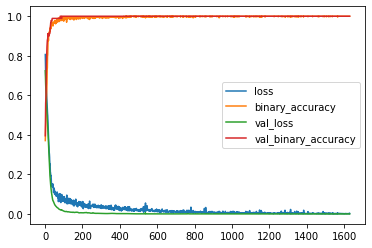

1628
(array([1628]),)


In [ ]:
# Beste aantal epochs zoeken

for key in history.history.keys():
    plt.plot(np.arange(1, n_epochs+1), history.history[key], label=key)
plt.legend()
plt.show()

print(np.argmin(history.history['val_loss']))
print(np.where(history.history['val_loss'] == np.min(history.history['val_loss'])))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=90a57419-7b7b-4aa4-8a97-858f9f98a849' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>